# (Try to) identify signals of gentrification in London from Airbnb data

Building on previous scripts (twitter sentiment and foursquare gentrification), this script uses data from [Inside AirBnB](https://insideairbnb.com/) and an LLM to see whether there might be indicators of the level of gentrification in an area. Ultimately we would like to repeat this for different years to see if gentrification patterns emerge.

In [14]:
import os
import re

import pandas as pd
import numpy as np
import geopandas as gpd

from datetime import datetime

from pygments.lexers.textfmts import TodotxtLexer
from together import Together  # pip install together



## Data

Data were downloaded for London from [Inside AirBnB](https://insideairbnb.com/get-the-data/) for 06 September, 2024. I use the three 'details' files:
   - `listings.csv.gz`
   - `reviews.csv.gz`
   - `neighbourhoods.geojson`

The downloaded files need to be placed in a directory called [airbnb-london](./airbnb-london) in the same directory as this script (not uploaded to github).

In [3]:
from networkx.classes import restricted_view

listings = pd.read_csv("airbnb-london/listings.csv.gz")
reviews = pd.read_csv("airbnb-london/reviews.csv.gz")
neighbourhoods = gpd.read_file("airbnb-london/neighbourhoods.geojson")

# Use the lat/lon columsn to make the listings a geodataframe
listings = gpd.GeoDataFrame(listings, geometry=gpd.points_from_xy(listings.longitude, listings.latitude))

In [10]:
listings

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry
0,70820,https://www.airbnb.com/rooms/70820,20240923134023,2024-09-23,previous scrape,City View - Sarah's double room.,A good sized room with a comfy double bed and ...,The neighbourhood is friendly and welcoming; m...,https://a0.muscache.com/pictures/b33c30be-56a0...,360195,...,4.76,4.76,NaN,f,5,0,5,0,1.47,POINT (-2.59183 51.43843)
1,117122,https://www.airbnb.com/rooms/117122,20240923134023,2024-09-23,city scrape,City Centre-Waterside Retreat,My Harbourside apartment centrally located min...,This area is on the water and has splendid vie...,https://a0.muscache.com/pictures/13b41142-0946...,591555,...,4.97,4.88,NaN,f,1,0,1,0,1.22,POINT (-2.61 51.44976)
2,176306,https://www.airbnb.com/rooms/176306,20240923134023,2024-09-23,city scrape,The White Room - Central Bristol Art House Ga...,"A small double room in an artist's house, with...","Southville is pretty darn hip, frankly. North ...",https://a0.muscache.com/pictures/e1e7fdfc-9db5...,708175,...,4.75,4.72,NaN,f,1,0,1,0,0.39,POINT (-2.60297 51.44174)
3,307634,https://www.airbnb.com/rooms/307634,20240923134023,2024-09-23,city scrape,"'The Sunset Room' Peaceful, Clear Home","Close to Bristol and Bath Railway Path, leadin...",Located in the cosmopolitan and bohemian commu...,https://a0.muscache.com/pictures/e1be9894-84fb...,1582810,...,4.85,4.73,NaN,f,3,0,3,0,0.48,POINT (-2.5569 51.46487)
4,390781,https://www.airbnb.com/rooms/390781,20240923134023,2024-09-23,previous scrape,"Cosy large room nr TV studios, Paintworks & st...",A room with a shared bathroom in an old Victor...,"Meals/food not provided, as the house is next ...",https://a0.muscache.com/pictures/77fed43a-04c9...,1954565,...,4.72,4.84,NaN,f,2,0,2,0,0.39,POINT (-2.55783 51.44444)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2639,1246838113868532396,https://www.airbnb.com/rooms/1246838113868532396,20240923134023,2024-09-23,city scrape,higgihaus Apartment 1 Clare Street Aparthotel,An extraordinary extended stay boutique aparth...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,164934575,...,NaN,NaN,NaN,f,27,27,0,0,NaN,POINT (-2.5944 51.45278)
2640,1247069104371725209,https://www.airbnb.com/rooms/1247069104371725209,20240923134023,2024-09-23,city scrape,3 Bedroom House in Whichurch,This three bedroom stylish property is in prim...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,597324133,...,NaN,NaN,NaN,f,1,1,0,0,NaN,POINT (-2.57638 51.41684)
2641,1247178906966071125,https://www.airbnb.com/rooms/1247178906966071125,20240923134023,2024-09-23,city scrape,Lovely room in St Werburgh’s,A cosy room in the heart of St. Werburghs. New...,NaN,https://a0.muscache.com/pictures/hosting/Hosti...,359833837,...,NaN,NaN,NaN,f,1,0,1,0,NaN,POINT (-2.57331 51.47107)
2642,1247202832256700106,https://www.airbnb.com/rooms/1247202832256700106,20240923134023,2024-09-23,city scrape,Cosy Cottage in Bristol,A stunning cosy getaway located within a natur...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,19621534,...,NaN,NaN,NaN,t,1,1,0,0,NaN,POINT (-2.54513 51.48672)


In [11]:
reviews

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,70820,8163487,2013-10-18,7538116,Neralee,We loved our stay with Sarah in Bristol. She w...
1,70820,8397676,2013-10-28,9601180,Terry,Sarah gave us and Laddie our dog a very warm w...
2,70820,8706695,2013-11-12,9697980,Alice,Exactly as described on the site and praised b...
3,70820,13024371,2014-05-17,2388955,Thomas,"Sarah was great. She was warm and welcoming, e..."
4,70820,14247963,2014-06-15,16317003,Dimitrije,The experience was really great at Sarah's hou...
...,...,...,...,...,...,...
138031,1241239971617639036,1249888205467164214,2024-09-20,597632200,Nathan,Kav was a good host very welcoming on my stay ...
138032,1243267678488262329,1246294227667787767,2024-09-15,21478328,Jenny,"Fab clean double room, friendly hosts! Highly ..."
138033,1243267678488262329,1247795424220121480,2024-09-17,90048893,Céleste,Hôte attentif et sympathique. Chambre et salle...
138034,1243267678488262329,1249914805363142260,2024-09-20,6196408,Nicholas,"Room was clean & spacious, bathroom was great,..."


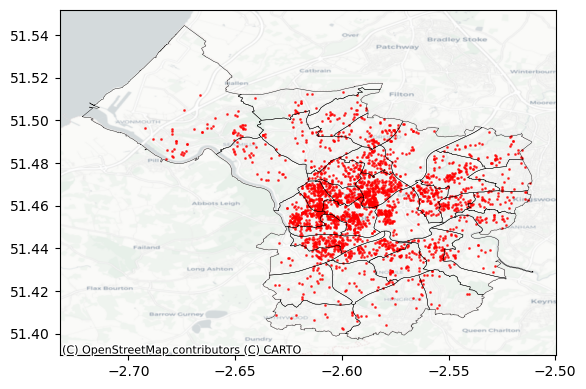

In [23]:
ax = neighbourhoods.plot()
listings.plot(ax=ax, color='red', markersize=0.1, alpha=0.1)

## Gentrification in Barnet (a test)

Choose one neighbourhood to see whether this works at all. Use Barnet for no particular reason other than I grew up there (and it has about an average number of listings).

Initially just use the listing descriptions. Later we can try the reviews for the listings as well by merging on IDs


In [45]:
barnet_listings = listings[listings.neighbourhood_cleansed == "Barnet"]
#df = df.merge(reviews, how='left', left_on='id', right_on='listing_id')
barnet_listings.loc[:, ['id', 'description', 'neighborhood_overview']]

,id,description,neighborhood_overview
19,41445,The apartment is on the ground floor (no stair...,Quite area popular with families
31,42010,Blenheim Lodge was built in 1878 when there we...,We have a unique cinema called the Phoenix whi...
35,44384,A stunning double room with great views.<br />...,NaN
193,294177,A fully equipped studio apartment where you fe...,NEARBY ATTRACTIONS<br /><br />-ROYAL AIR FORCE...
223,388674,NaN,NaN
...,...,...,...
95952,1237575807664762531,NaN,NaN
95991,1237641783461389930,NaN,NaN
95997,1237660088414847095,The whole group will enjoy easy access to ever...,NaN
96012,1237676529358063196,Your family will be close to everything when y...,NaN


### LLM gentrification function

Uses the Together.AI API.

A function that takes a batch of tweets and uses the Together API to classify them. The `system_prompt` variable contains the prompt that will be sent to the API; individual tweets are appended to this.

The LLM requires some parameter values. Here are the settings that chatGPT recommended (with defaults, that I decided not to use, in brackets)

1.	max_tokens:
	-	Recommendation: 50 (~1000 or more)
2.	temperature:
	-	Recommendation: 0.2 (0.7)
	-	Explanation: A lower temperature makes the model’s output more deterministic, which is ideal for scoring tasks where consistency is important.
3.	top_p:
	-	Recommendation: 0.9 (0.7)
	-	Explanation: This value balances the randomness and coherence of the output by considering tokens with a cumulative probability up to 90%.
4.	top_k:
	-	Recommendation: 40 (50)
	-	Explanation: Limits the model to consider the top 40 probable next tokens, which helps in generating relevant responses.
5.	repetition_penalty:
	-	Recommendation: 1.1 (1)
	-	Explanation: Slightly penalizes repeated tokens to prevent the model from producing redundant information.

In [43]:
# Create a log with the current time
LOG_FILE = os.path.join("logs", datetime.now().strftime("%Y-%m-%d-%H%M%S.log"))
def log(msg):
    with open(LOG_FILE, 'a') as f:
        f.write(msg)

In [44]:
def get_gentrification_scores(batch_tweets, system_prompt, client, batch_index=0, max_tokens=1000):
    """
    Retrieves gentrification scores for a batch of tweets using the Together AI API.

    Parameters
    ----------
    batch_tweets : pandas.DataFrame
        A DataFrame containing the tweets for the current batch.
        It must include a 'text' column with the tweet content.
    system_prompt : str
        The system prompt to be sent to the Together AI API.
        The tweet texts will be appended to this prompt.
    client : Together
        The Together client object to use for API calls.
    batch_index : int
        An optional starting index of the current batch.
        This is used to align the predicted sentiments with the original DataFrame indices.

    Returns
    -------
    ids : list of int
        A list of DataFrame indices corresponding to each tweet in the batch.
        These indices align with the main DataFrame from which this batch was drawn.
    sentiments : list of str
        A list of predicted gentrification scores for each tweet in the batch.
        Possible values are 1 (not suggestive of gentrification) to 5 (highly suggestive).
    explanations : list of str
        Explanations that the LLM returns giving it's reason for the the chosen score
        (these may or may not happen depending on the prompt, and the LLM's mood!)
    """

    # Prepare the list of tweets
    tweet_list = "\n".join([f"{idx + 1}. {tweet}"
                            for idx, tweet in enumerate(batch_tweets.text.values)])

    # Create the system prompt
    system_prompt = f"{system_prompt}\n\n{tweet_list}"
    #print("PROMPT:", system_prompt, "\n\n")

    # Prepare the messages
    messages = [
        {
            "role": "system",
            "content": system_prompt
        }
    ]

    # Call the API using parameters that ChatGPT recommends for this task
    response = client.chat.completions.create(
        #model="meta-llama/Llama-3.2-90B-Vision-Instruct-Turbo",
        model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
        messages=messages,
        max_tokens=max_tokens,  # max length of output (in case I get the prompt wront and it talks for ages...)
        temperature=0.2,  # lower for more deterministic
        top_p=0.9,  # ??
        top_k=40,  # ??
        repetition_penalty=1,
        stop=["<|eot_id|>", "<|eom_id|>"],
        truncate=130560,  # ??
        stream=False  # Set stream to False to get the full response
    )

    # Extract the assistant's reply and get the IDs and scores
    assistant_reply = response.choices[0].message.content.strip()

    # Useful to have a full log for debugging etc
    log(f"{datetime.now().strftime('%Y-%m-%d-%H%M%S')}\n" \
        f"**MESSAGE**\n{messages}\n" \
        f"**RESPONSE**\n{assistant_reply}\n\n")

    # Parse the IDs and scores (and, if available the explanation for the score)
    ids = []
    scores = []
    explanations = []

    # Regex pattern to extract the line number, score, and optional text from a line
    pattern = r'''
        ^\s*              # Start of line, allow leading whitespace
        (\d+)             # Capture Group 1: The line number
        \s*[.:]\s*        # A dot or colon with optional whitespace
        (?:Score:\s+)?    # Optionally match "Score:" followed by one or more spaces
        (\d+)             # Capture Group 2: The score (one or more digits)
        (?:\s*(.*))?      # Optional text after the score (Group 3)
        $                 # End of the line
    '''

    # Desipte being told not to, sometimes the reply starts with
    # 'Here are the scores:' or 'Here are the analyses:'
    # Remove that, and any whitespace at the start or end
    assistant_reply = re.sub(r'^\s*Here are the scores:\s*', '', assistant_reply).strip()
    assistant_reply = re.sub(r'^\s*Here are the analyses:\s*', '', assistant_reply).strip()

    # Analyse the reply line-by-line
    lines = assistant_reply.strip().split('\n')
    error_count = 0  # Return -1 on an error (and count the number of errors at the same time)
    for i, line in enumerate(lines):
        # Ignore lines that are empty once they have been stripped
        line = line.strip()
        if not line:
            continue

        # Try to match the line
        match = re.match(pattern, line, re.VERBOSE)
        if match:
            # Extract the index and score from the match groups
            index = int(match.group(1))
            score = int(match.group(2))
            explanation = match.group(3)
            log(f"{i} {line}\n\t{index},{score},{explanation}")
            # Validate the score range
            if 1 <= score <= 5:
                ids.append(index)
                scores.append(score)
                explanations.append(explanation)
            else:
                msg = f"Warning: Score {score} out of range on line {i}: '{line}'"
                print(msg)
                log(msg)
                error_count += 1
        else:
            msg = f"\n*********************\n" \
                  f"Warning: Invalid format on line {i}: '{line}'.\n" \
                  f"The full response was: \n{assistant_reply}\n" \
                  f"*********************\n"
            print(msg)
            log(msg)
            error_count += 1
            break

        if index-1 >= len(batch_tweets):
            msg = f"Found {index} tweets, but there are more lines. Assuming remaining lines are junk and ignoring them."
            log(msg)
            print(msg)
            break

    if error_count > 0:
        # There was an error, set scores to -1 and assume tweet IDs from
        # 1 to len(batch_tweets).
        scores = [-1] * len(batch_tweets)
        ids = [x + 1 for x in range(len(batch_tweets))]
        explanations = ["ERROR"] * len(batch_tweets)

    # Compute dataframe indices
    df_ids = [batch_index + int(id) - 1 for id in ids]

    assert len(df_ids) == len(scores), f"Length of ids ({len(df_ids)} does not match length of scores ({len(scores)})."

    return df_ids, scores, explanations



### The Prompt

Use the slightly adapted Foursquare one for now

In [51]:
# This prompt asks for no explanation
foursquare_prompt_concise = """
You are an expert in urban studies with a deep understanding of gentrification and how it is discussed in public discourse. I will provide you with an AirBnB listing, and your task is to analyze its text and determine the extent to which it suggests that the neighborhood or area referenced is experiencing gentrification. Specifically:

Read the listing closely and identify any words, phrases, or implications that might indicate signs of gentrification, such as mentions of new luxury developments, rising rents, displacement of long-time residents, upscale amenities (e.g., artisanal coffee shops, craft breweries), changing demographics, or neighborhood 'revitalization'.

Consider both explicit and implicit cues. Explicit cues directly mention new businesses or rising prices, while implicit cues might reflect subtle neighborhood changes.

Assign a score from 1 to 5, where 1 means not suggestive of gentrification and 5 means highly suggestive.

Provide your answer strictly in the format ‘1. Score’, ‘2. Score’, '3. Score', etc., without any additional explanation or commentary.
"""

# This prompt asks explicitly for an explanation (note may need to make sure that 'max_tokens' in the call to the API is sufficiently large

foursquare_prompt_explanatory = """
You are an expert in urban studies with a deep understanding of gentrification and how it is discussed in public discourse. I will provide you with an AirBnB listing, and your task is to analyze its text and determine the extent to which it suggests that the neighborhood or area referenced is experiencing gentrification. Specifically:

Read the listing closely and identify any words, phrases, or implications that might indicate signs of gentrification, such as mentions of new luxury developments, rising rents, displacement of long-time residents, upscale amenities (e.g., artisanal coffee shops, craft breweries), changing demographics, or neighborhood 'revitalization'.

Consider both explicit and implicit cues. Explicit cues directly mention new businesses or rising prices, while implicit cues might reflect subtle neighborhood changes.

Assign a score from 1 to 5, where 1 means not suggestive of gentrification and 5 means highly suggestive.

Explain your reasoning in 1-2 sentences, referencing the specific words or phrases in the tweet that led you to your conclusion.

Provide your answer strictly in the format ‘1. Score. Reasoning.’, ‘2. Score. Reasoning’, '3. Score. Reasoning', etc., without any additional explanation or commentary.
"""

# The propmpt to use
prompt = foursquare_prompt_explanatory

### Run the LLM

In [55]:
# Get the API key from a file
with open('together.ai_key.txt', 'r') as f:
    api_key = f.readline().strip()

client = Together(api_key=api_key)

# We need a single 'text' column. Combine the listing text and the neighbourhood overview
barnet_listings.loc[:, 'text'] = barnet_listings['description'] + " " + barnet_listings['neighborhood_overview']
# Drop Nan
barnet_listings = barnet_listings.dropna(subset=['text'])
barnet_listings['text']

# Sample for now
df = barnet_listings.sample(10).copy()

print(f"Will query the LM for {len(df)} items")

assert len(df) < 100, "Too many tweets to process in one go. Please reduce the number of tweets."

# Ensure the index is consecutive and ascending
df = df.reset_index(drop=True)
# To store the results
df['gentrification_prediction'] = None

# Batch processing
batch_size = 5
for i in range(0, len(df), batch_size):
    # Get the batch of tweets
    batch_tweets = df.loc[i:i + batch_size - 1, :]

    # Get sentiments using the function
    print(f"Submitting batch {i//len(batch_tweets)+1} of {len(df)//len(batch_tweets)}...")

    ids, sentiments, explanations = get_gentrification_scores(
        batch_tweets, prompt, client, batch_index=i, max_tokens=1500)

    # Update the DataFrame with the predictions
    df.loc[ids, 'gentrification_prediction'] = sentiments
    df.loc[ids, 'explanation'] = explanations

print("Finished")

Will query the LM for 10 items
Submitting batch 1 of 2...
Submitting batch 2 of 2...
Finished


In [57]:
df.to_csv("~/Desktop/temp.csv")
df


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry,text,gentrification_prediction,explanation
0,690489369849081585,https://www.airbnb.com/rooms/690489369849081585,20240906025501,2024-09-06,city scrape,3 bedroom apartment in the heart of London.,"Kick back and relax in this calm and clean , s...",calm and friendlyneighbourhood,https://a0.muscache.com/pictures/087d8ae2-9763...,34359250,...,f,1,1,0,0,0.36,POINT (-0.25191 51.5898),"Kick back and relax in this calm and clean , s...",1,. Reasoning: The listing describes the neighbo...
1,39973380,https://www.airbnb.com/rooms/39973380,20240906025501,2024-09-06,city scrape,★ Great Location ★ Cosy & Bright Flat★Entire Home,Our very well lit one bedroom flat is perfect ...,We live in a beautiful neighborhood surrounded...,https://a0.muscache.com/pictures/ee87cfad-c889...,25829777,...,f,3,3,0,0,0.79,POINT (-0.20497 51.56406),Our very well lit one bedroom flat is perfect ...,1,. Reasoning: The listing highlights the neighb...
2,1122383946134576257,https://www.airbnb.com/rooms/1122383946134576257,20240906025501,2024-09-06,city scrape,homely Luxury Apartment Finchley,Welcome to our cosy Finchley retreat! Immerse ...,Discover the natural beauty that surrounds Fin...,https://a0.muscache.com/pictures/miso/Hosting-...,43891732,...,f,33,33,0,0,0.94,POINT (-0.17735 51.61412),Welcome to our cosy Finchley retreat! Immerse ...,3,". Reasoning: The listing mentions ""luxurious a..."
3,24408041,https://www.airbnb.com/rooms/24408041,20240906025501,2024-09-06,city scrape,Spacious double bedroom in arty flat,Double room in arty and charming ground floor ...,Muswell Hill is like a little village! But jus...,https://a0.muscache.com/pictures/848698ef-da81...,182429051,...,f,2,0,2,0,0.31,POINT (-0.14377 51.60697),Double room in arty and charming ground floor ...,2,. Reasoning: The listing describes Muswell Hil...
4,17086075,https://www.airbnb.com/rooms/17086075,20240906025501,2024-09-10,previous scrape,Sunny room+balcony+desk - Feathering heights!,This is a beautiful room with private balcony....,This area is a new built complex attractive la...,https://a0.muscache.com/pictures/df603915-bdab...,114659182,...,f,1,0,1,0,NaN,POINT (-0.24584 51.59605),This is a beautiful room with private balcony....,4,". Reasoning: The listing mentions a ""new built..."
5,709223528979930143,https://www.airbnb.com/rooms/709223528979930143,20240906025501,2024-09-06,city scrape,New! Lovely 2 Bed Serviced Apart with free par...,Enjoy a stylish experience at this centrally-l...,Residential and peaceful neighbourhood with ea...,https://a0.muscache.com/pictures/b376a72f-60c3...,286960592,...,t,7,7,0,0,0.68,POINT (-0.21525 51.56758),Enjoy a stylish experience at this centrally-l...,2,". The listing mentions a ""recently renovated"" ..."
6,952590370210805148,https://www.airbnb.com/rooms/952590370210805148,20240906025501,2024-09-10,previous scrape,Like a studio bedroom,Keep it simple at this peaceful and near centr...,Peaceful,https://a0.muscache.com/pictures/41997f04-51bf...,433421718,...,f,2,0,2,0,0.30,POINT (-0.19935 51.57255),Keep it simple at this peaceful and near centr...,1,. The listing does not provide any information...
7,958737630523075765,https://www.airbnb.com/rooms/958737630523075765,20240906025501,2024-09-10,previous scrape,Modern Ensuite in Leafy Suburb,"Experience comfort at our ensuite room, 8 mins...","Nestled on the outskirts of London, Cockfoster...",https://a0.muscache.com/pictures/airflow/Hosti...,208434608,...,f,1,0,1,0,5.83,POINT (-0.15261 51.64832),"Experience comfort at our ensuite room, 8 mins...",2,". The listing mentions the ""suburban charm"" an..."
8,659340218743908488,https://www.airbnb.com/rooms/659340218743908488,20240906025501,2024-09-10,previ

Todo

Not really sure what to make of these. The LLM explanations make sense, but there are lots of other possible interpretations of the text.

 - [ ] Run the variability analysis to see how consistent the LLM output is.

 - [ ] Try running over a large volume to see if the output scores make any sense spatially?